In [1]:
%load_ext autoreload
%autoreload 2
#tensorboard doesn't work with keras model callbacks! needs tensorflow.keras
from preprocess import *
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
SR = 16000
fname = './test/NIP0ZHC60.wav'   #shh
wav, _ = librosa.core.load(fname, sr=SR)
#for long audio files can get N seconds of audio
#wav = wav[:N*SR]
print("This audio is {} seconds long".format(wav.shape[0]/SR))

This audio is 1.6 seconds long


In [3]:
#https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html
#see examples, options
spectrogram = librosa.feature.melspectrogram(wav, sr = SR)
#spectrogram = librosa.feature.melspectrogram(wav, sr = SR, n_fft=8)
spectrogram.shape

(128, 51)

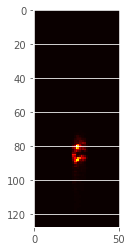

In [4]:
matplotlib.style.use('ggplot')
plt.imshow(spectrogram, cmap='hot', interpolation='nearest');

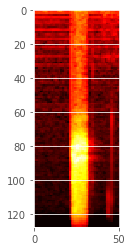

In [5]:
#this log_spec result is what I trained models with
#not crazy about cpu % it uses which is about same as mfcc
log_spec = librosa.power_to_db(spectrogram, ref=np.max)
plt.imshow(log_spec, cmap='hot', interpolation='nearest');

In [6]:
#https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
mfcc = librosa.feature.mfcc(wav, sr = SR, n_mfcc=40)
mfcc.shape

(40, 51)

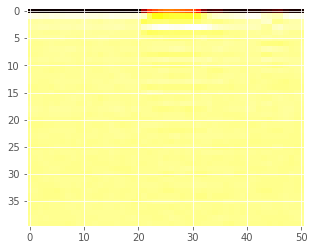

In [7]:
matplotlib.style.use('ggplot')
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

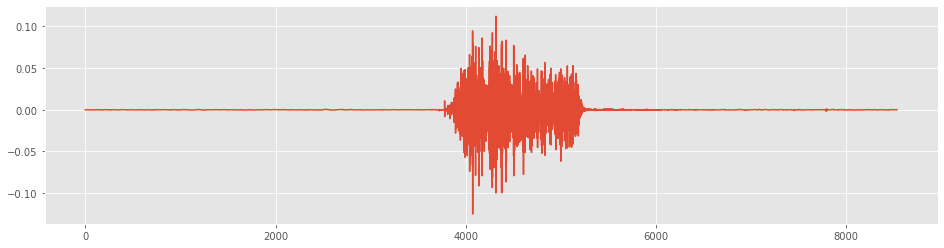

In [8]:
wav, _ = librosa.core.load(fname, sr=SR)
#The DeadSimple project does downsampling by taking every 3 samples, yet still uses SR=16000 for mfcc argument
#below you can try changing SR argument to SR/3 and see how the output changes, unsure of how it affects
#training but the output/visualization is clearly different
wav = wav[::3]
plt.figure(figsize=(16, 4))
plt.plot(wav, '-', )

In [9]:
#Seems [::3] results in an error when computing mfccs "Audio buffer is not Fortran-contiguous"
wav = np.asfortranarray(wav) 
mfcc = librosa.feature.mfcc(wav, sr = SR, n_mfcc=40)
#mfcc = librosa.feature.mfcc(wav, sr = SR/3, n_mfcc=40)
mfcc.shape

(40, 17)

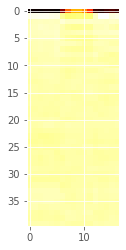

In [10]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

(128, 17)
(128, 17)


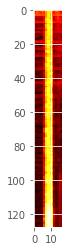

In [11]:
#spectrogram = librosa.feature.melspectrogram(wav, sr = SR)
spectrogram = librosa.feature.melspectrogram(wav, sr = SR/3)
print(spectrogram.shape)
log_spec = librosa.power_to_db(spectrogram, ref=np.max)
print(log_spec.shape)
plt.imshow(log_spec, cmap='hot', interpolation='nearest');
#TODO question: does calling power_to_db help the model or is this waste of cpu and only helpful for visualization?

# Padding and Augmentation

short length 15360


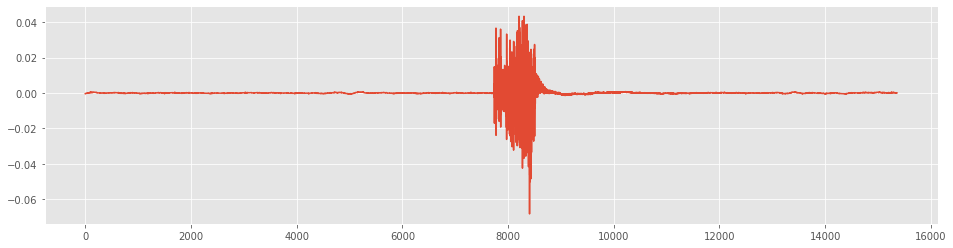

In [12]:
fname = './test/short.wav'
short, _ = librosa.core.load(fname, sr=SR)
print('short length', len(short))
plt.figure(figsize=(16, 4))
plt.plot(short, '-', )

long length 25600


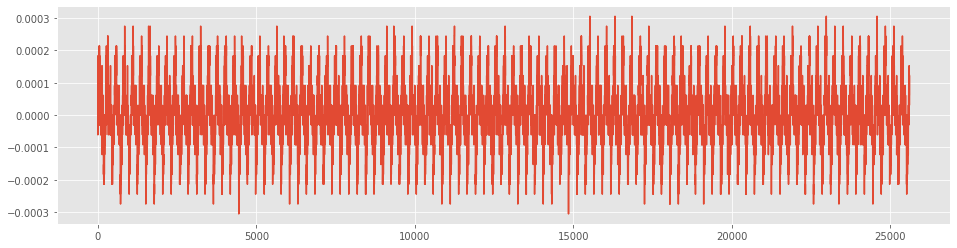

In [13]:
fname = './test/sil.wav'
sil, _ = librosa.core.load(fname, sr=SR)
print('long length', len(sil))
plt.figure(figsize=(16, 4))
plt.plot(sil, '-', )

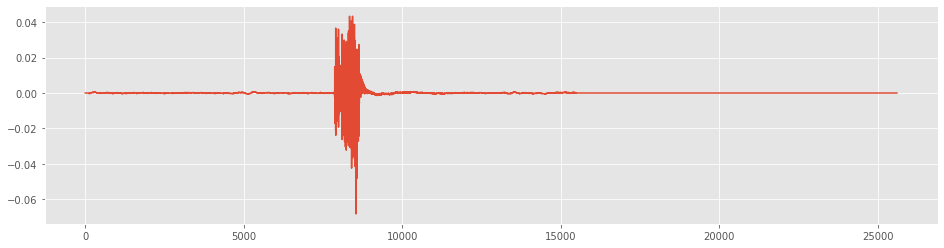

In [15]:
#Concern is padding with zeros will result in the model just learning the length of the underlying samples
#or some other arbitrary feature. Using real background noise/silence from the recording env is likely better.
#Unsure if 1d conv net or spectrogram, mfcc models may be more sensitive to these problems than others.
zero_padded = random_pad(short, len(sil))
plt.figure(figsize=(16, 4))
plt.plot(zero_padded, '-', )

In [16]:
#random_pad_with uses underlying padding values, there are probably similar numpy functions
a = np.arange(10)
b = np.array([100,101,102,103])
c = random_pad_with(b,a)
c

array([  0,   1,   2,   3, 100, 101, 102, 103,   8,   9])

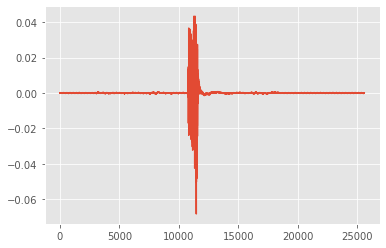

In [17]:
sil_padded = random_pad_with(short, sil)
plt.plot(sil_padded, '-', )

In [19]:
#this assumes all files in silence dir are the max length
def random_silence_wav():
    for _, _, filenames in os.walk('./data/silence'):
        filename = filenames[np.random.randint(len(filenames))]
        wav, _ = librosa.core.load('./data/silence/' + filename, sr=16000)
        return wav

silence_wave = random_silence_wav()
len(silence_wave)

16384

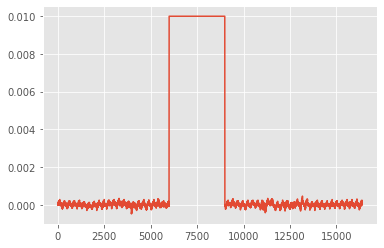

In [21]:
really_short = np.array([.01] * 3000)
padded = random_silence_pad(really_short)
plt.plot(padded, '-', )
#this grabs a random silence file from ./data/silence as the padding data
#if used, make sure all silence wavs are the max length!